# Guide to Extracting Data w/ APIs from Polar H10

<img src='https://media.dcrainmaker.com/images/2021/12/Polar-H10-Heart-Rate-Strap-In-Depth-Review.jpg' height="500">

*^ A picture of the polar h10 heart rate monitor ^*

The Polar H10 is a $80 ECG chest strap heart rate monitor. It is worn attached to a strap and wrapped tight around the sternum.

While the H10 is well known for its accuracy in measuring heart rate, it is also capable of tracking metrics like movement speed, pace, and distance traveled.

All of the data kept and calculated by the H10 can be easily accessed via the Polar Beat app, which automatically stores the training data to the cloud.

In the following sections, we will present what we have learned from using the Polar H10 and its associated platform for extracting data and doing simple analysis.

Through the API, we will be able to extract the following parameters (in bold are parameters we will be using in this notebook). Per Activity means one measurement through a single session of exercise. Per second means one measurement every second throughout an exercise.

Additionally, the H10 is capable of recording raw RR intervals. However, since the official Polar App does not use this functionality, we will be using an optional third party app EliteHRV for this purpose. This is just one way to get RR intervals from the H10, many other ways exist!

We will be able to extract the following parameters. Per Activity means one measurement through a single session of exercise. Per second means one measurement every second throughout an exercise.

Parameter Name  | Sampling Frequency
-------------------|-----------------
Calories |  Per Activity
Duration | Per Activity
Sessions | Per day
Continuous Heart Rate |  Per second
Heart Rate Variability | Per second

In this guide, we sequentially cover the following **nine** topics:

1. **Set up**<br>
  - A quick guide on setting up the Polar H10
2. **Authentication/Authorization**<br>
   - Requires only username and password, no OAuth.
3. **Data extraction**<br>
  - We get data via `wearipedia` in a couple lines of code.
4. **Data Exporting**
  - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
    - We will also provide an example of plotting data from EliteHRV
7. **Data visualization & analysis** <br>
  - 7.1 Visualizing Continuous Heart Rate data <br>
  - 7.2 Visualizing session Fit/Fat percents <br>
  - 7.3 Visualizing Heart Rate Averages and Sessions over a Month <br>
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Data Analysis** <br>
  - 9.1 Analyzing correlation between Average Heart Rate and Calories Burned per Minute <br>
  - 9.2 Analyzing how activity intensity compares in first half and second half of a session

**Note that we are not making any scientific claims here as our sample size is small and the data collection process was not rigorously vetted (it is our own data), only demonstrating that this code could potentially be used to perform rigorous analyses in the future.**

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Set up

## Participant Setup

Dear Participant,

Once you unbox your Polar H10, please set up the device by following the video:


*   Video Guide: https://www.youtube.com/watch?v=vw0WV-PWtcw


Make sure that your phone is paired to it using the Polar Flow login credentials (email and password) given to you by the study coordinator.

Additionally, if your study coordinator is using Elite HRV, make sure to your phone is paired to the H10 device using the Elite HRV login credentials given to you.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`
2. Create a Polar Flow account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.
5. Install the `wearipedia` Python package to easily extract data from this device.

OPTIONAL: Elite HRV
While the Polar H10 is a versatile device capable of measuring raw RR intervals, Polar does not officially register this data. To access the RR intervals, we will use a 3rd party application, EliteHRV, which can store RR data.
1. Using email created from above, create a EliteHRV account with the email and some random password.
2. Subscribe to the EliteHRV dashboard ($8/month) to get the ability to download the data from the account.

In [ ]:
!pip install git+https://github.com/Stanford-Health/wearipedia

  Cloning https://github.com/Stanford-Health/wearipedia to /tmp/pip-req-build-yxmozch_
  Running command git clone --filter=blob:none --quiet https://github.com/Stanford-Health/wearipedia /tmp/pip-req-build-yxmozch_
  Resolved https://github.com/Stanford-Health/wearipedia to commit e128fc36d93c90718c404fcaf5bbc8b84811f849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#2. Authentication/Authorization
To obtain access to data, authorization is required. All you'll need to do here is just put in your email and password for your Polar H10 device. We'll use this username and password to extract the data in the sections below.

The Elite HRV emails and passwords are optional - read the setup in the above section to see how you can get started with Elite HRV!

In [ ]:
#@title Enter Polar login credentials (and EliteHRV if you have them)

email_address = 'foo@gmail.com' #@param {type:"string"}
password = 'foopass'#@param {type:"string"}
elite_hrv_email = "foo@gmail.com" #@param {type:"string"}
elite_hrv_password = "foopass" #@param {type:"string"}

# 3. Data extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox. Additionally, if you have an elite HRV account or want to generate synthetic HRV data, click the hrv checkbox (this is optional!).

In [ ]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2022-06-10' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}
hrv = True #@param {type: "boolean"}

In [ ]:
import wearipedia
from io import StringIO

device = wearipedia.get_device("polar/h10")

params = {"start_date": start_date, "end_date": end_date}
if not synthetic:
  device.authenticate({"email": email_address, "password": password, "elite_hrv_email": elite_hrv_email, "elite_hrv_password": elite_hrv_password})
  data = device.get_data("sessions", params = params)
  if hrv:
    rr_data = device.get_data("rr", params = params)
else:
  params = {"start_date": start_date, "end_date": end_date}
  data = device.get_data("sessions", params = params)
  rr_data = device.get_data("rr", params = params)

100%|██████████| 108/108 [00:00<00:00, 2442.68it/s]


To get a list of the days that actually have data, we can list out the keys for the returned data. Note it might not be feasible to actually print out the entire set of returned data, as it can be quite large.

In [ ]:
print(rr_data.keys())
print(data.keys())

dict_keys(['2022-03-02', '2022-03-01', '2022-03-03', '2022-03-04', '2022-03-06', '2022-03-08', '2022-03-10', '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-14', '2022-03-15', '2022-03-19', '2022-03-18', '2022-03-17', '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-27', '2022-03-28', '2022-03-29', '2022-04-01', '2022-03-31', '2022-04-04', '2022-04-03', '2022-04-06', '2022-04-05', '2022-04-08', '2022-04-09', '2022-04-10', '2022-04-12', '2022-04-11', '2022-04-13', '2022-04-17', '2022-04-16', '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21', '2022-04-24', '2022-04-25', '2022-04-27', '2022-04-28', '2022-04-30', '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-07', '2022-05-08', '2022-05-06', '2022-05-11', '2022-05-09', '2022-05-13', '2022-05-12', '2022-05-14', '2022-05-15', '2022-05-16', '2022-05-19', '2022-05-18', '2022-05-20', '2022-05-21', '2022-05-22', '2022-05-24', '2022-05-23', '2022-05-25', '2022-05-27', '2022-05-28', '2022-05-

# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [ ]:
import json

hrs = [data[k]['heart_rates'] for k in data.keys()]
calories = [data[k]['calories'] for k in data.keys()]
hr_avgs = [sum(data[k]['heart_rates']) / (data[k]['minutes'] * 60) for k in data.keys()]
durations = [data[k]['minutes'] for k in data.keys()]

json.dump(list(data.keys()), open("dates.json", "w"))
json.dump(calories, open("calories.json", "w"))
json.dump(hrs, open("hrs.json", "w"))
json.dump(hr_avgs, open("hr_avgs.json", "w"))
json.dump(durations, open("durations.json", "w"))

complete = {
    "dates": list(data.keys()),
    "calories": calories,
    "hrs": hrs,
    "hr_avgs": hr_avgs,
    "durations": durations,
}


json.dump(complete, open("complete.json", "w"))

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX will require us to first process the data into a pandas dataframe format, which can then be converted into our desired file type.

Here we will export three separate files: the first will contain heart rate data (labeled by date and time), and the second will contain daily summary data such as calories, average heart rate, and minutes (labeled by date). Additionally, we will make a third dataframe containing only heart rate data for one session (of your choice) to help us with further visualizations and analysis in the following sections of this notebook.

In [ ]:
day = "" #@param {type: "string"}

# set the day of interest automatically if not specified
if day == "":
  for key in data.keys():
    df = pd.DataFrame(data[key]['heart_rates'],columns=['bpm'])
    heart_rts = list(df["bpm"])

    fat_percent = np.count_nonzero(np.array(heart_rts) < 140) / len(heart_rts)
    fit_percent = int((1 - fat_percent )*100)
    fat_percent = int(fat_percent*100)
    if fit_percent != 0 and fat_percent != 0:
      day = key
      break


In [ ]:
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
import copy

# Third dataframe and list of dataframes:
hr_df = None
hr_dfs = []

# 1. First dataframe
# we initialize a variable all_df that will hold all the session data for this dataframe
all_df = []
sorted_keys = sorted(data.keys(), key=lambda x: pd.to_datetime(x))
for key in sorted_keys:
  # determine duration of a workout
  duration = data[key]['minutes']*60

  # set the start time of every session to 0s
  start_time = timedelta(hours=0, minutes=0, seconds=0)

  # create times columns which is the series of seconds in the duration
  times = [str(start_time + timedelta(seconds=i)).zfill(8) for i in range(int(duration))]
  tdf = pd.DataFrame(zip(times,data[key]['heart_rates']),columns=['time','bpm'])

  # mapping is a function that will format the time to include the date of exercise
  mapping = lambda x: np.datetime64(key+ " " + x)
  tdf["time"] = tdf["time"].apply(mapping)

  # append the new dataframe for the session to the main dataframe
  # save the dataframe as hr_df which is our "third" dataframe
  if key == day:
    hr_df = tdf

  all_df.append(tdf)
  hr_dfs.append(copy.deepcopy(tdf))
all_df = pd.concat(all_df)
#print("DataFrame 1: All heart rates")
#display(all_df)

# 2. Second dataframe
df2 = []
avg_rate = 0
for key in data.keys():
  # calculate the average heart rate for this session
  avg_rate = sum(data[key]['heart_rates']) / (data[key]['minutes'] * 60)

  # append the new session summary to it
  tdf = pd.DataFrame([[key,data[key]['minutes'],data[key]['calories'], avg_rate]],columns=['day','minutes','calories', 'avg_rate'])
  df2.append(tdf)
df2 = pd.concat(df2)
#print("DataFrame 2: Summary Data")
#display(df2)

# 3. Third dataframe
print("DataFrame 3: Single session heart rate")
display(hr_df)

DataFrame 3: Single session heart rate


,time,bpm
0,2022-03-02 00:00:00,82.093303
1,2022-03-02 00:00:01,81.584621
2,2022-03-02 00:00:02,82.469640
3,2022-03-02 00:00:03,84.233853
4,2022-03-02 00:00:04,84.571887
...,...,...
3295,2022-03-02 00:54:55,182.157029
3296,2022-03-02 00:54:56,183.531295
3297,2022-03-02 00:54:57,183.569614
3298,2022-03-02 00:54:58,182.940630


With this, we have retrieved all the data we need! Now we can start visualizing our data.

# 5. Adherence

The device simulator already automatically randomly deletes exercise session data. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level). Additionally, while unlikely, there is a potential for the heart rate monitor to fall off mid session and for the participant to not realize. We will simulate this as well.

Then, we will detect these instances of non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will simulate non-adherence by deleting or inserting 0s (indicating sensor removal) from a certain % of blocks either at the day level or week level, with user input.

In [ ]:
#@title Non-adherence simulation
block_level = "day" #@param ["day","week"]
adherence_percent = 0.65 #@param {type:"slider", min:0, max:1, step:0.01}

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import copy
import random

if block_level == "day":
  block_length = 1
elif block_level == "week":
    block_length = 7

dates = np.array(list(data.keys()))

num_blocks = len(dates) // block_length

num_blocks_to_remove = int((1-adherence_percent) * num_blocks)

remove = np.random.choice(dates, replace=False, size=num_blocks_to_remove)

adhered_data = copy.deepcopy(data)
adhered_dates = copy.deepcopy(list(data.keys()))

for key in remove:
  # some non-adherence will be completely removed data sessions
  if np.random.rand() < 0.8:
    adhered_data.pop(key)
    adhered_dates.remove(key)
  # other non-adherence may be because the device stopped recording data part way through the session
  else:
    adhered_data[key]['heart_rates'] += (list(np.zeros(100)))

And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may not use their device for days or weeks at a time.

If you would like to see exactly how many points fewer, run the following cell:

In [ ]:
print(f'From the original {len(data.keys())} datapoints, we\'ve removed {len(data.keys())-len(adhered_data.keys())} of them!')

From the original 81 datapoints, we've removed 23 of them!




Now let's detect non-adherence. We will plot the days when the participant uses the watch and when they do not, as well as the days where they record complete sessions (i.e. they do not remove the sensor partway through their session).

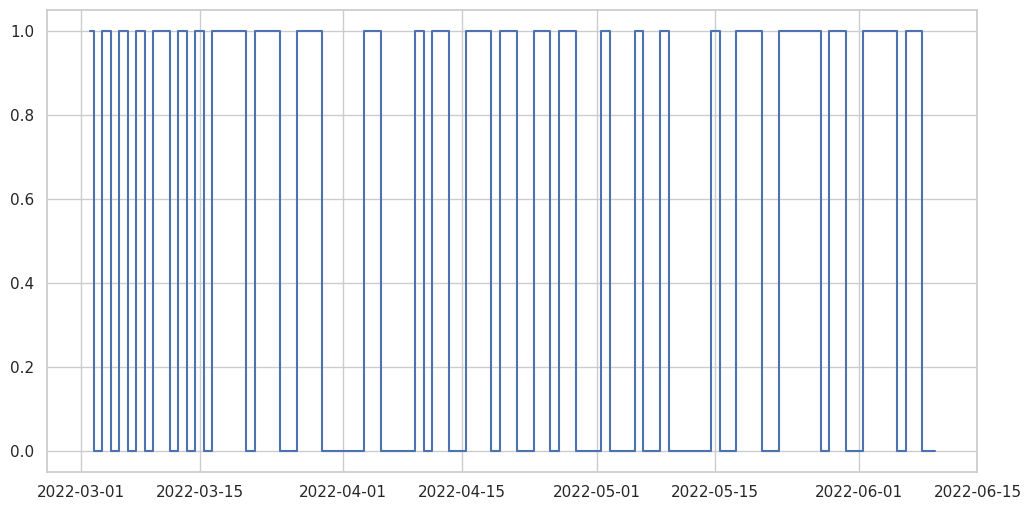

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

datelist = pd.date_range(start_date, end_date)
is_wearing = []

for date in datelist:
  day = datetime.strftime(date, "%Y-%m-%d")
  if day in adhered_dates:
    if 0.0 in adhered_data[day]['heart_rates']:
      is_wearing.append(0)
    else:
      is_wearing.append(1)
  else:
    is_wearing.append(0)

plt.figure(figsize=(12, 6));
plt.plot(datelist,is_wearing,drawstyle="steps-mid");

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

First, run the below cell ONCE and select a date option from the dropdown. Then, run the graph cell.

In [ ]:
#@title Choose a date!
import ipywidgets as widgets
date_list = list(data.keys())
date_picker = widgets.Dropdown(options=date_list, value=date_list[0])

display(date_picker)

Dropdown(options=('2022-03-02', '2022-03-01', '2022-03-03', '2022-03-04', '2022-03-06', '2022-03-08', '2022-03…

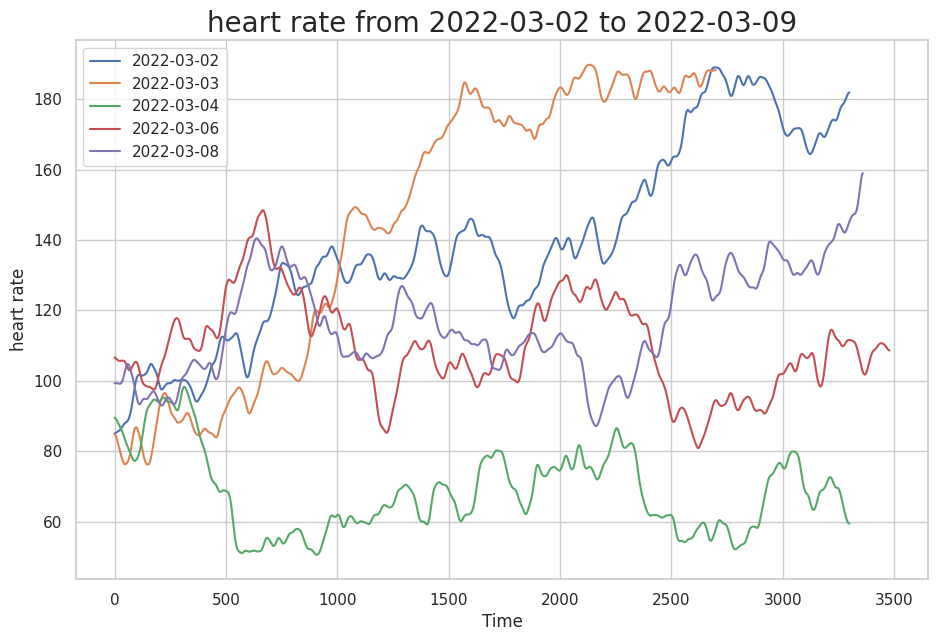

In [ ]:
#@title Basic Plot
feature = "heart rate" #@param ["heart rate", "average heart rate", "calories"]
#start_date = "2023-05-10" #@param {type:"date"}
time_interval = "one week" #@param ["one day", "one week", "full time"]
smoothness = 0.05 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

from scipy.special import y0
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from scipy.ndimage import gaussian_filter1d

start_date = date_picker.value

if time_interval == "one day":
  datelist = pd.date_range(start_date, periods=1)
elif time_interval == "one week":
  datelist = pd.date_range(start_date, periods=7)
elif time_interval == "full time":
  datelist = pd.date_range(start_date, end_date)

plt.figure(figsize=(11,7))

for d in datelist:
  end = d + timedelta(days=1)
  start = d

  if feature == "heart rate":
    tempdf = all_df[all_df["time"].map(lambda x: datetime.strptime(datetime.strftime(x,"%Y-%m-%d"),"%Y-%m-%d") >= start and datetime.strptime(datetime.strftime(x,"%Y-%m-%d"),"%Y-%m-%d") < end)]
    y = tempdf["bpm"]
    x = list(range(len(y)))#tempdf["time"]
    sigma = 200*smoothness
  elif feature == "average heart rate":
    tempdf = df2[df2["day"].map(lambda x: datetime.strptime(x,"%Y-%m-%d") <= end and datetime.strptime(x,"%Y-%m-%d") >= start)]
    y = tempdf["avg_rate"]
    x = tempdf["day"]
    sigma = 5*smoothness
  elif feature == "calories":
    tempdf = df2[df2["day"].map(lambda x: datetime.strptime(x,"%Y-%m-%d") <= end and datetime.strptime(x,"%Y-%m-%d") >= start)]
    y = tempdf["calories"]
    x = tempdf["day"]
    sigma = 5*smoothness

  if smooth_plot:
    y = list(gaussian_filter1d(y, sigma=sigma))

  if feature == "heart rate" and len(x):
    plt.plot(x, y, label=datetime.strftime(start,'%Y-%m-%d'))
  else:
    plt.bar(x,y)

title_fillin = feature
if time_interval == "one day":
  plt.title(f"{title_fillin} on {start_date}",fontsize=20)
else:
  plt.title(f"{title_fillin} from {start_date} to {datetime.strftime(end,'%Y-%m-%d')}",fontsize=20)
plt.xlabel("Time")
plt.ylabel(title_fillin)

plt.legend(loc=0)

This plot allows you to quickly scan various sessions of your data and for different kinds of measurements (heart rate, average heart rate, and calories), which enables easy and fast data exploration.

# 6A. Graphing HRV data using EliteHRV

If you also have an EliteHRV account set up and data stored in EliteHRV, here's how you can visualize the HRV data!

We first start with our raw RR data which EliteHRV allows us to collect. Let's collect everything into the same dataframe.

In [ ]:
all_hrv = []
for key in rr_data.keys():
  # set the start time of every session to 0s
  start_time = timedelta(hours=0, minutes=0, seconds=0)
  # create times columns which is the series of seconds in the duration
  times = [str(start_time + timedelta(seconds=i)).zfill(8) for i in range(len(rr_data[key]["time"]))]
  tdf = pd.DataFrame(zip(times,rr_data[key]['rr']),columns=['time','rr'])

  # mapping is a function that will format the time to include the date of exercise
  mapping = lambda x: np.datetime64(key+ " " + x)
  tdf["time"] = tdf["time"].apply(mapping)


  all_hrv.append(tdf)
all_hrv = pd.concat(all_hrv)


The RR intervals must be processed to become the HRV data, and there are many ways to do this. Here, we choose a common method: RMSSD (Root mean square standard deviation) for HRV calculation. Let's write a function for calculating the HRV:

In [ ]:
import numpy as np

# rr intervals in milliseconds
# gets Hrv list calculated from RMSSD (Root mean square standard deviation)
def toHrv(rr):
  # gets the HRV around so  me window of rr
  window = 150
  l = 0
  ps = 0
  hrv = []
  for i in range(len(rr)-1):
    if i-l > window:
      ps -= (rr[l+1] - rr[l])
      l += 1
    ps += rr[i+1]-rr[i]

    hrv.append(np.sqrt(np.square(ps)/(i-l+1)))
  return hrv

hrvr = toHrv(list(all_hrv["rr"]))

Now we can plot the HRV data much like we have done for our other data!

**NOTE:** The example data plotted here displays synthetic data generated using Wearipedia, simulating HRV during intense exercise. Hence the data may seem unnaturally low. Feel free to plug in your own data to see a more accurate graph!

In [ ]:
#@title Choose a date!
import ipywidgets as widgets
date_list = list(rr_data.keys())
date_picker = widgets.Dropdown(options=date_list, value=date_list[0])

display(date_picker)

Dropdown(options=('2022-03-02', '2022-03-01', '2022-03-03', '2022-03-04', '2022-03-06', '2022-03-08', '2022-03…

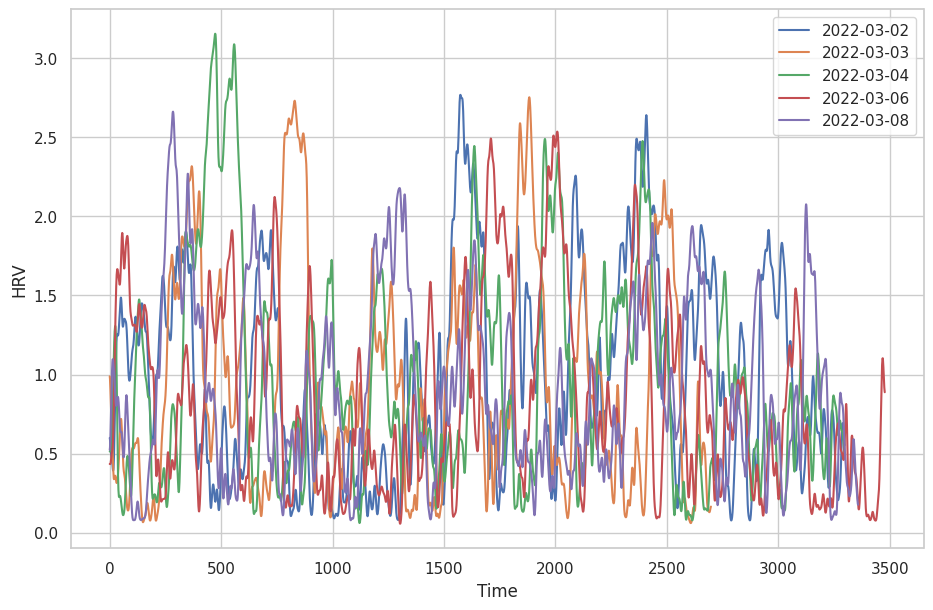

In [ ]:
#@title Basic Plot
feature = "HRV"
#start_date = "2023-05-10" #@param {type:"date"}
time_interval = "one week" #@param ["one day", "one week", "full time"]
smoothness = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

from scipy.special import y0
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from scipy.ndimage import gaussian_filter1d

start_date = date_picker.value

if time_interval == "one day":
  datelist = pd.date_range(start_date, periods=1)
elif time_interval == "one week":
  datelist = pd.date_range(start_date, periods=7)
elif time_interval == "full time":
  datelist = pd.date_range(start_date, end_date)

plt.figure(figsize=(11,7))
#plt.ylim(0,30)

for d in datelist:
  end = d + timedelta(days=1)
  start = d

  tempdf = all_hrv[all_hrv["time"].map(lambda x: datetime.strptime(datetime.strftime(x,"%Y-%m-%d"),"%Y-%m-%d") >= start and datetime.strptime(datetime.strftime(x,"%Y-%m-%d"),"%Y-%m-%d") < end)]
  y = toHrv(list(tempdf["rr"]))
  x = list(range(len(y))) #tempdf["time"]
  sigma = 200*smoothness

  if smooth_plot:
    y = list(gaussian_filter1d(y, sigma=sigma))
  if len(x):
    plt.plot(x, y, label=datetime.strftime(start,'%Y-%m-%d'))

plt.xlabel("Time");
plt.ylabel("HRV");
plt.legend(loc=0);

# 7. Advanced Visualization

## 7.1 Continuous Heart Rate Graph

One of the graphs that you see after checking on a training session on the polar flow website is this continuous heart rate chart.

<img src="https://i.imgur.com/CpvRIHc.png" width='750px' />

This plot shows the continuous heart rate data recorded by the H10 monitor throughout the participant's workout session. This graph adds visual separation to heart rate records under and over 140 bpm. This is helpful because at lower exercise intensities, more fat calories are burned, whereas at high intensities more carbohydrate calories are burned.

To begin plotting this chart, we want to extract the heart rates and put them into a list so they can be easily read by our plotting utility matplotlib.

In [ ]:
import pandas as pd

heart_rts = list(hr_df["bpm"])
#we must add in '2000-01-10' as a dummy date to help with formatting concerns
times = list(hr_df["time"])

We will now graph this using the matplotlib [line plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) function, which will give us the base graph, after which we can focus on aesthetics.

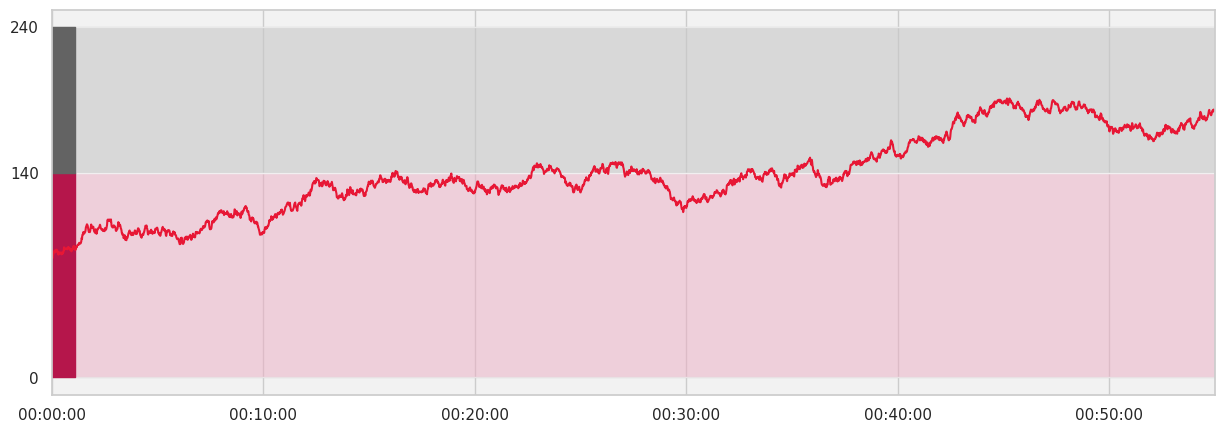

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from datetime import timedelta

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('#f2f2f2')

ax = plt.gca()
plt.plot(times, heart_rts, color='#e71735')

#set x axis values
xts = np.arange(min(times), max(times), timedelta(minutes=10))
ax.set_xticks(xts)
ax.set_xticklabels(xts)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

#set left y axis
yts = [0,140,240]
ax.set_yticks(yts)

#ax.set_yscale('function', functions=(forward,inverse))
ax.axhspan(0, 140, facecolor='#ecaec4', alpha=0.5)
ax.axhspan(140, 240, facecolor='#c7c7c7', alpha=0.6)
ax.fill_between(times[:int(len(times)/50)], 0, 140, color='#b5164b', alpha=1)
ax.fill_between(times[:int(len(times)/50)], 140, 240, color='#636363', alpha=1)

#cut off the edges
plt.xlim(times[0], times[len(times)-1]);

This plot is important because it shows us the heart rate of the participant for each second, giving us a detailed look at a particular workout session. Also, the red and gray zones allow us to quickly identify the level of vigor at which the user exercised.

## 7.2 Visualizing Participants Fit/Fat Percents

What if we want a quantitative measure of vigor for a participant's exercise session? Polar's website displays just this in the following chart.

<img src="https://i.imgur.com/Pl35nrW.png" width='350px' />

This chart shows the percent of the exercise in which the participant exercised at high intensity (fit) and the percent spent in low intensity exercise (fat).

We will need to first extract the percent of time spent in each zone. Since polar defines low intensity as being below 140 bpm and high intensity being above, we can use our heart rate data to determine this information.

In [ ]:
import pandas as pd

heart_rts = list(hr_df["bpm"])

fat_percent = np.count_nonzero(np.array(heart_rts) < 140) / len(heart_rts)
fit_percent = int((1 - fat_percent )*100)
fat_percent = int(fat_percent*100)

ranges = [0, 140, 240]
z1 = hr_df.groupby(pd.cut(hr_df.bpm, ranges), as_index=False).count()
z2 = pd.to_datetime(z1['bpm'], unit='s')
z2 = pd.DataFrame(z2.dt.strftime('%H:%M:%S'))
display(z2['bpm'])

0    00:31:58
1    00:23:02
Name: bpm, dtype: object

z2 is exactly the heart rate zone data, as we wanted. Now we want to set up two more python arrays that we will use as the y-axis labels, shown here. This data is already available in our z2 series, so we can extract them as necessary.

In [ ]:
zones = ['1','2']
times = [e for e in z1['bpm']][::-1]
time_labels = [e for e in z2['bpm']]

The zones array will be the left side y-axis label, and the times will be the actual data. We can place these in a pandas dataframe so it will be easier to plot using the python matplotlib library.

In [ ]:
import pandas as pd

d = {"zones":zones, "times": times}
df1 = pd.DataFrame(data=d)
df1.set_index('zones', inplace=True)

And now we can finally plot the data. We will be using the [horizontal bar plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html) from matplotlib, barh. Since we already have the data we need, we can use barh to directly plot the necessary bars, after which we can apply our desired styling to make the graph look like the one pictured.

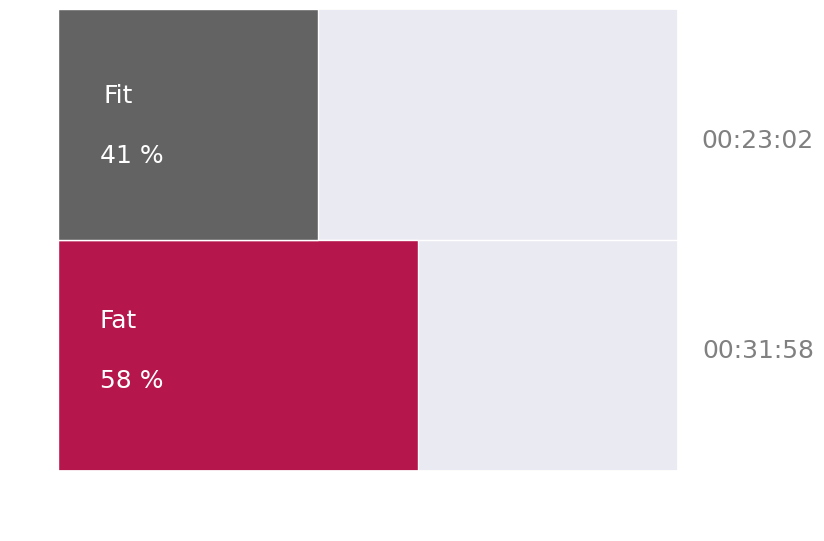

In [ ]:
from matplotlib import pyplot as plt, patches
import seaborn as sns

sns.set_theme(style="dark")
fig1, ax = plt.subplots(figsize=(8,6))
clrs = ["#636363", "#b5164b"] #colors array for the zones

#plot the base graph
plt. margins(y=0)
plt.xlim(0, sum(i for i in df1["times"])) #this sets the graph to have its width equal to the total session time
bar1 = ax.barh(df1.index[::-1], df1["times"][::-1], align="center", height=1., color = clrs[::-1]) #plot the bar graph
plt.xticks(color='w') #hide the x tick labels
plt.yticks(color='w')
ax.tick_params(axis='both', labelsize=25, pad=12.5)

# Adding the times for each zone
for i in range(len(time_labels)):
  plt.text(1.,0.3 + 0.35*i,time_labels[i],fontsize=18,transform=fig1.transFigure,
          horizontalalignment='center', weight=300, color="gray")

# Adding the labels for each zone
plt.text(.2,0.35,"Fat",color="white", fontsize=18,transform=fig1.transFigure,
          horizontalalignment='center', weight=300)
plt.text(.2175,0.25, str(fat_percent)+" %",color="white", fontsize=18,transform=fig1.transFigure,
          horizontalalignment='center', weight=300)

plt.text(.2,0.725,"Fit",color="white", fontsize=18,transform=fig1.transFigure,
          horizontalalignment='center', weight=300)
plt.text(.2175,0.625, str(fit_percent)+" %",color="white", fontsize=18,transform=fig1.transFigure,
          horizontalalignment='center', weight=300)

#set grid lines separating bars
ax.set_yticks([0.5], minor=True)
ax.yaxis.grid(True, which='minor')

This plot is important because it gives us a quick way to understand the general distribution of activity levels throughout a participant's exercise session, and can display how vigorous the exercise session was.

# 7.3 Session Histogram

Another graph that polar displays is a bar chart showing the duration of exercise sessions throughout the past thirty days along with a plot of the average heart rates per session.


<img src='https://i.imgur.com/AkrUlco.png' width='750px'>

To start we want to extract the necessary data. This will include:


*   Dates of exercises
*   Durations of each exercise
*   Average heart rates of each exercise



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

df4 = df2
if len(data.keys()) == 1:
  for i in range(1,30):
    tdf = pd.DataFrame([[(pd.Timestamp(list(data.keys())[0])+pd.DateOffset(days=1*i)).strftime('%Y-%m-%d'),0,0, avg_rate]],columns=['day','minutes','calories', 'avg_rate'])
    df4 = df4.append(tdf)

durations = []
avg_rates = []
dates = []
day_array = list(df4['day'])
rate_array = list(df4['avg_rate'])
duration_array = list(df4['minutes'])
for i in range(len(df4['day'])):

  if datetime.strptime(day_array[i],'%Y-%M-%d') < (datetime.strptime(start_date,'%Y-%M-%d') + timedelta(days=30)) and datetime.strptime(day_array[i],'%Y-%M-%d') >= datetime.strptime(start_date,'%Y-%M-%d'):
    dates.append(np.datetime64(day_array[i]))
    durations.append(duration_array[i]*60000)
    avg_rates.append(rate_array[i])

c = sorted(dates, key=lambda x: x)
s = dates[0]
dates = []
for d in c:
  if d > (s+np.timedelta64(30,'D')):
    break
  else:
    dates.append(d)
dates = dates[:30] # we will only plot a month of data just like in the original

Now that we have everything we need, we can move on to plotting the graph!

To do this we will start by plotting a [matplotlib bar graph](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html), which will represent the durations of each exercise. Then we will overlay this plot with a second graph, the [matplotlib line plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). This is all we need for the base graph!

All that remains after is to add the necessary styling to achieve the graph pictured above.

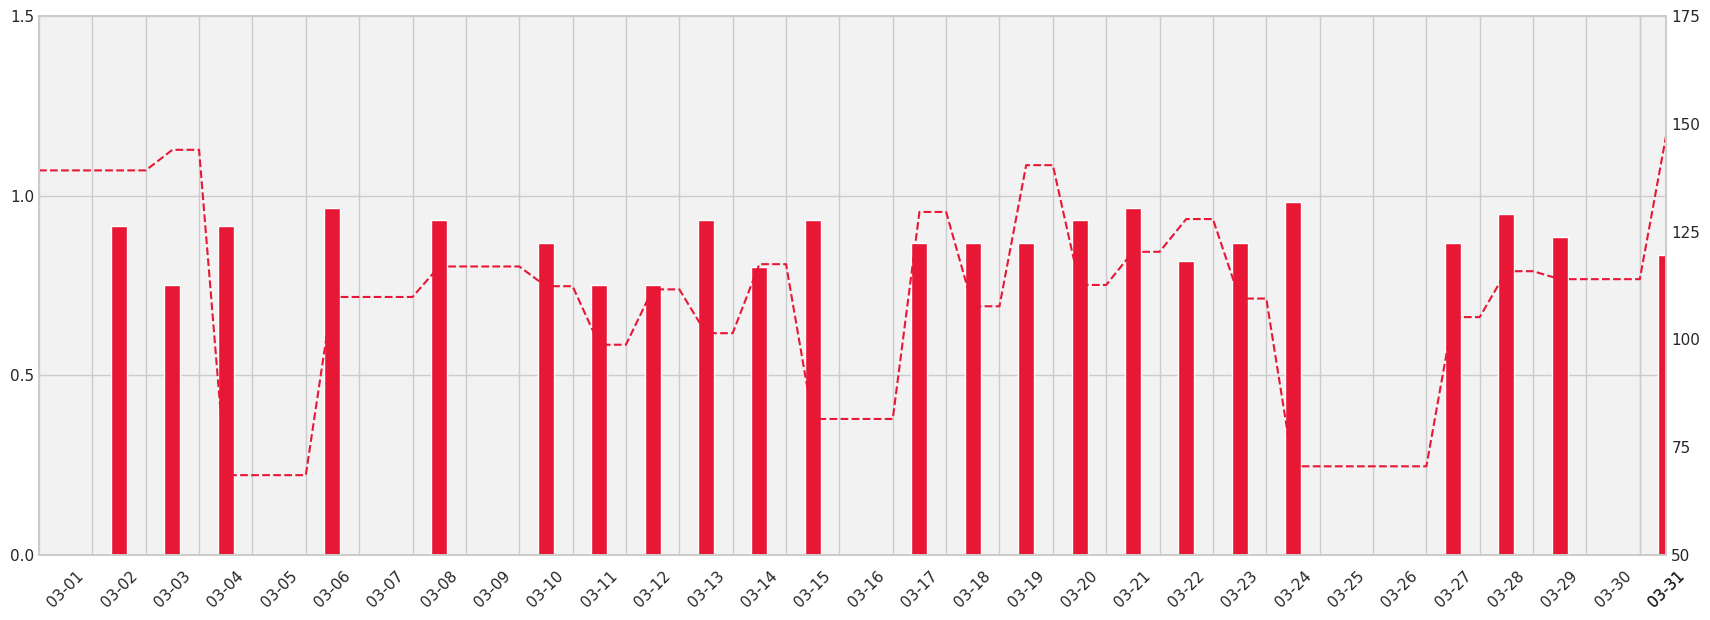

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import copy
import pandas as pd
import warnings

# ignore unecessary warnings
warnings.filterwarnings("ignore")
#set the style of the plot, initialize it
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(21,7)) # 24, 8
ax.set_facecolor('#f2f2f2')

#before we begin, we need to add in a buffer at either end of the data so we can extend the graph
rbound = np.datetime64((pd.Timestamp(dates[len(dates)-1])).strftime('%Y-%m-%d'))
lbound = np.datetime64((pd.Timestamp(dates[0]) - pd.DateOffset(days=1)).strftime('%Y-%m-%d'))
xdates = list(pd.date_range(start=lbound, end=rbound))
xdates.append(xdates[len(xdates)-1])

gridticks = copy.deepcopy(xdates)
xdates += list(np.array(xdates) - timedelta(hours=12))
xdates = sorted(xdates, key=lambda x: x) # check

#process and fill our data arrays so that they match dimensions of x axis
points = {np.datetime64(datetime.strftime(pd.to_datetime(date), '%Y-%m-%d')):(avg_rate,duration) for date, avg_rate, duration in zip(dates,avg_rates,durations)}

data1 = []
data2 = {}
for i in range(len(xdates)):
  cdate = np.datetime64(datetime.strftime(xdates[i],'%Y-%m-%d'))
  if i == 0:
    added = points[np.datetime64(datetime.strftime(xdates[3],'%Y-%m-%d'))][0]
  # if even (is artifical)
  if pd.Timestamp(xdates[i]).hour == 12:
    data1.append(added)
    continue
  if cdate in points:
    added = points[cdate][0]
    data1.append(added)
    data2[cdate] = points[cdate][1]/3600000
  else:
    data1.append(added)
    data2[cdate] = 0
plt.xticks(rotation=45)
ax2 = ax.twinx()

#plot the bar graph
ax.bar(data2.keys(),data2.values(), color ='#e71735', width=0.30)
ax.set_yticklabels(np.arange(0, 2., 0.5), weight='light')
ax.set_yticks(np.arange(0, 2., 0.5)) # 2nd param was: max(data2.values())+0.5 for adaptability

#plot the average heart rate
plt.plot(xdates, data1, color='#e71735', linestyle='dashed')
plt.xticks(gridticks)
ax.set_xticklabels(gridticks, weight='light')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

#clip the graph ends to get our desired look
axis = plt.axis()
plt.xlim(xdates[0], xdates[len(xdates)-2])
ax2.yaxis.grid(False)
ax2.set_yticks(np.arange(50,200,25))
ax2.set_yticklabels(np.arange(50, 200, 25), weight='light')

# shift grid lines so they are in between dates
gridticks = np.array(gridticks) - timedelta(hours=12)
ax.set_xticks(gridticks, minor=True)
ax.xaxis.grid(False)
ax.grid(which='minor')
ax.tick_params(axis='x', length=10, which='minor')

#hide ticks
ax2.tick_params(axis='y', length=0)
ax.tick_params(axis='y', length=0)

This plot is important because it shows us whether the participant wore the monitor and how long they wore the monitor each day. Additionally, their average heart rate throughout the session can be a basic indicator of the intensity of their exercises.

# 8. Outlier Detection and Data Cleaning

**NOTICE:** If you are using synthetically generated data, the analyses may yield unintuitive results due to the randomly generated nature of the data

In this section, we will detect outliers in our extracted data.

Since there are currently no outliers (by construction, since it is simulated to have none), we will manually inject a couple into our general sessions dataframe (the method for finding outliers here will work for any heart rate dataframe).

In [ ]:
import pandas as pd
import copy

outliers = pd.DataFrame({'time': ['01:11:52', '01:11:53'], 'bpm': [240, 20]})
#hr = pd.concat([hr_df, pd.DataFrame(outliers)],ignore_index=True)

hr = copy.deepcopy(hr_df)
random_indices = np.random.randint(0, len(hr), size=len(outliers))
# Insert each entry of the outliers dataframe at random indices in the larger dataframe
for i, row in outliers.iterrows():
  nrow = pd.DataFrame([row])
  hr = pd.concat([hr.iloc[:random_indices[i]], nrow, hr.iloc[random_indices[i]:]], ignore_index = True)

Now there are many known methods for finding outliers, but here we will use the z-score as a filter for finding them.

The formula for the z-score is


```
Z = (data point - mean of data set) / standard deviation
```
We will compute this formula on every data point in our data set, giving us a massive list of z-score values.

What the z score tells us is how far, in terms of standard deviations, any one data point is from the mean. In statistics, data points at increasing standard deviations away from the mean are less likely to occur. This means that the greater our z-score, the more unlikely for the data point to be real.

We can decide what distance from the mean constitutes an outlier by setting the **threshold** value, so if a data point's z-score is above that threshold we might guess it to be an outlier.

One intuitive idea is that the heart rate should not vary too much from one second to the next. To capitalize on this, we can improve our analysis by first calculating the distance each heart rate sample is away from neighboring heart rate samples. We can then use the z-scores to determine which heart rates differ from their neighbors by an unusually large margin. These will likely be our outliers.

In [ ]:
import math
import pandas as pd

nx = hr["bpm"]

distances = []

f = lambda x: x**2

#take the current count, subtract it by the points to its left and right some distance, then
#square each of these differences, add, then sqrt
for l1, l2, m, r1, r2 in zip(nx[:-4],nx[1:-3],nx[2:-2],nx[3:-1],nx[4:]):
  difference = math.sqrt(f(m-l1)+f(m-l2)+f(m-r1)+f(m-r2))
  distances.append(difference)

Now we can calculate our z-scores for the heart rate data in one training session, and identify those data points that seem like outliers. Luckily, we can save some time by using the [z-score function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) from scipy's statistics library, which will give us a z-score calculation for all data points.

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np

threshold = 3 #@param{type: "number"}
z_scores = np.abs(stats.zscore(nx))
hr['z'] = z_scores
outliers = hr.loc[hr['z'] > threshold]
print(hr.loc[hr['z'] > threshold])

cx = list(hr["bpm"].values)
for idx in hr.index[hr['z'] > threshold].tolist():
  vals = cx[idx-3:idx-2]+cx[idx-2:idx-1]+cx[idx+1:idx+2]+cx[idx+2:idx+3]
  mean_val = np.mean(vals)
  hr.loc[idx, 'bpm'] = mean_val

          time    bpm         z
1747  01:11:53   20.0  4.387843
2692  01:11:52  240.0  3.712764


It looks like the code was able to successfully identify the two outliers!

We can also visualize the two outliers by locating them in a graph of the heart rates. Run the cell below to check it out!

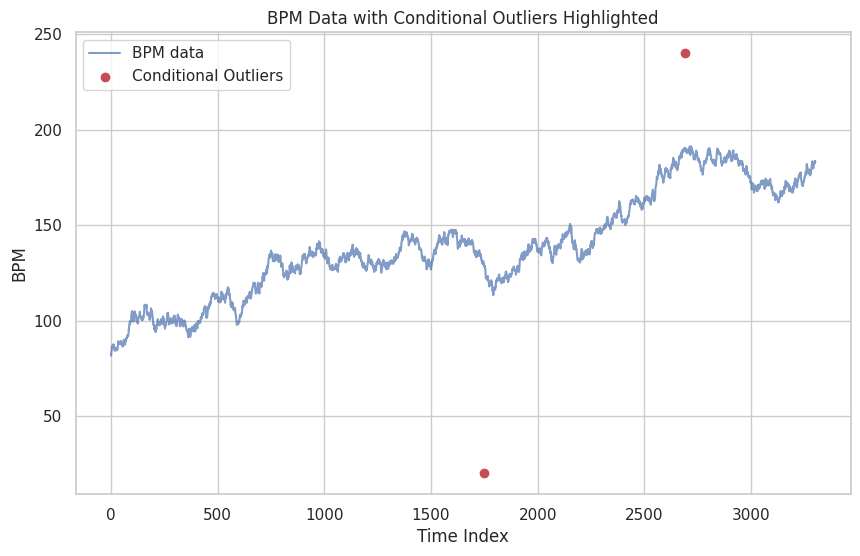

In [ ]:
# Plot HR data with conditional outliers highlighted (Plot adapted from the Biostrap notebook: https://colab.research.google.com/github/Stanford-Health/wearable-notebooks/blob/main/notebooks/biostrap_evo.ipynb#scrollTo=ysL4wqBcGC7j)
plt.figure(figsize=(10, 6))
plt.plot(hr['bpm'], label='BPM data', alpha=0.7)
plt.scatter(outliers.index, outliers['bpm'], color='r', label='Conditional Outliers')
plt.legend()
plt.title('BPM Data with Conditional Outliers Highlighted')
plt.xlabel('Time Index')
plt.ylabel('BPM')
plt.show()

# 9. Data Analysis

## 9.1 Correlation between average heart rate and calories burned


We want to test the hypothesis that for a session, the average heart rate correlates with the number of calories burned.

Let us begin by extracting the necessary data. This includes:


*   the average heart rate for each exercise session
*   the calories burned per minute for each exercise session



To do this we will refer to the exercise_data list of exercises which we kept from section 3. In practice you can use the following code:



```
avg_rates = [s['heart_rate']['average'] for s in exercise_data]
calories_per_minute = [s["calories"]/(float(pd.Timedelta(s["duration"]).total_seconds()/60)) for s in exercise_data]
```



In [ ]:
import pandas as pd

avg_rates = [avg_rate for avg_rate in df2['avg_rate']]
calories_per_minute = [c/(m) for c, m in zip(df2['calories'],df2['minutes'])]

And now we can actually graph the data to see the correlation. This is done by using a [seaborn linear regression plot](https://seaborn.pydata.org/generated/seaborn.lmplot.html) which we can use to visualize the correlation.

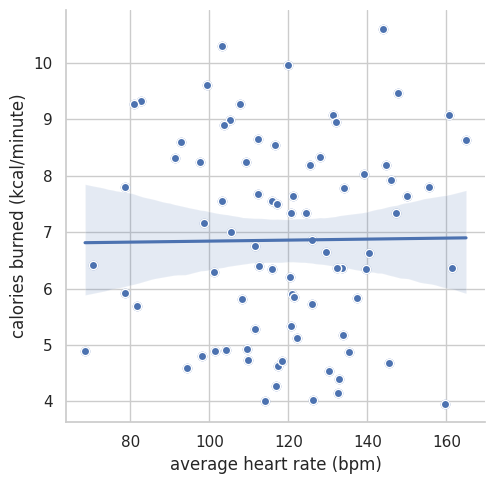

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the data
d = {'calories burned (kcal/minute)': calories_per_minute, 'average heart rate (bpm)': avg_rates}
df = pd.DataFrame(data=d)

graph = sns.lmplot(data=df, y='calories burned (kcal/minute)', x='average heart rate (bpm)')

graph.map(plt.scatter, 'average heart rate (bpm)','calories burned (kcal/minute)', edgecolor ="w").add_legend()
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)

From the plot, we can check how well the line of best fit matches the actual data points. This is our first step in determining if there's a correlation between the two variables.

But we can do more to confirm this correlation - we can calculate the p-value to determine statistical significance using scipy's stats library, as shown here:

In [ ]:
from scipy import stats

p_value = stats.linregress(calories_per_minute,avg_rates)[3]
correlation_coefficient = stats.pearsonr(calories_per_minute, avg_rates)[0]
print("P value: " + str(p_value))
print("Correlation coefficient: " + str(correlation_coefficient))

P value: 0.9223926445025898
Correlation coefficient: 0.010995044123266413


If the p-value is less than 0.05, we have statistical significance. This means that there is less than a 5% probability that the datapoints of our dataset occurred by chance.
In addition, our correlation coefficient tells us how strong of a correlation exists between the variables. A value closer to -1.0 implies a strongly negative correlation, and value close to 1.0 implies a strongly postitive correlation.
This relationship is intuitive, because Polar uses an equation to calculate the calories burned. But looking at this data allows to see that polar's calorie counter makes sense!

**NOTE:** You might not observe correlation between the variables if you used our synthetic generator, as the data is randomized.

## 9.2 T test on activity intensity through workout

We might also be interested in determining whether the participant exercises with different overall intensity at different halves of their sessions.

The T-test is a statistical test used to compare the mean of some value in two separate groups, thus highlighting any differences between the averages. Here our first group will be the first half of an exercise session, and the second group will be the second half of an exercise session.

Choosing on exercise session to focus on, we can use the T-test to see if the exercise intensity in the first half of the session is different from the intensity in the second half.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def differ(df):
  rows = len(df.index)
  f = df.iloc[range(rows//2)]["bpm"]
  s = df.iloc[range(rows//2,rows)]["bpm"]
  return ttest_ind(f,s)

print(differ(hr_df))

TtestResult(statistic=-55.658346131639576, pvalue=0.0, df=3298.0)


Since the t-test returned a negative value, this implies the our "first" group has a lower mean than the "second" group. What this means is that the sample mean heart rate in the first half of the exercise session is less than the sample mean heart rate in the second half of the session. Further, since our pvalue is small (< 0.05), we can reject the null hypothesis and conclude that the the first half of the exercise tended to have lower heart rates than the second half.

We can now repeat this process on multiple exercise sessions and visualize our findings in a plot, giving us a view of the participant's exercise habits (i.e. whether they tend to slow down throughout a session, or whether their intensity increases).

Text(0, 0.5, 'T-test of exercise intensity between first half and second half of session')

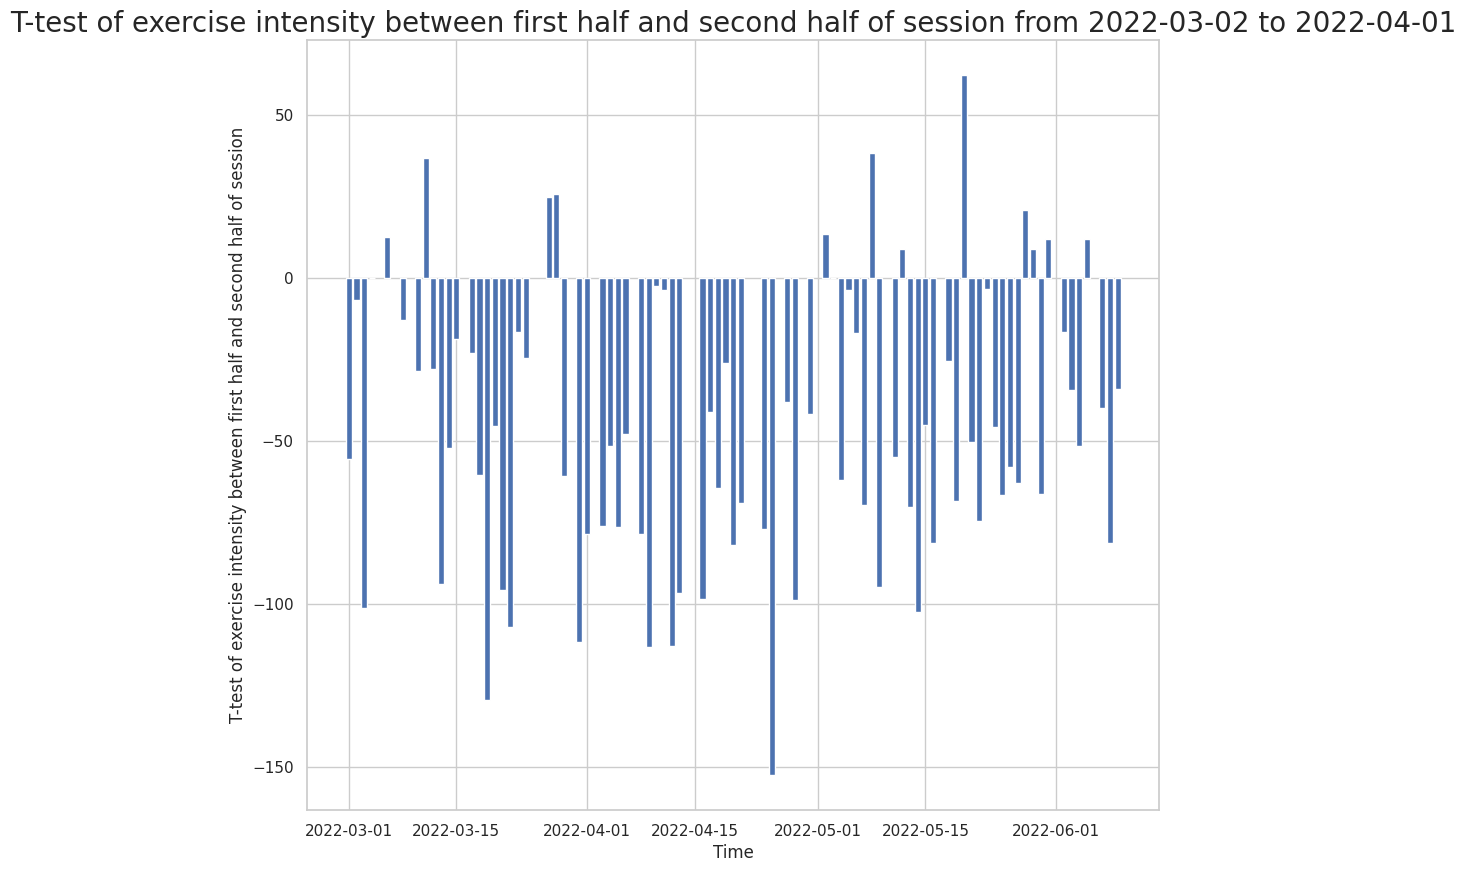

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

y = []
x = df2["day"]

for df in hr_dfs:
  v,p = differ(df)
  if p < 0.05:
    y.append(v)
  else:
    # there is no difference
    y.append(0)

plt.figure(figsize=(11,10))
plt.bar(np.asarray(x, dtype='datetime64[s]'), y)
end = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=30)
plt.title(f"T-test of exercise intensity between first half and second half of session from {start_date} to {datetime.strftime(end,'%Y-%m-%d')}",fontsize=20)
plt.xlabel("Time")
plt.ylabel("T-test of exercise intensity between first half and second half of session")

Based on our graph, there are much more negative t-test results than positive ones. This shows that the patient, in general, tends to have increased exercise intensity in the second half of their workout sessions!